(parameters_recovery)=
# Recovering computational parameters from observed behaviours

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ComputationalPsychiatry/pyhgf/blob/master/docs/source/notebooks/4-Parameter_recovery.ipynb)

In [1]:
import sys
from IPython.utils import io
if 'google.colab' in sys.modules:

  with io.capture_output() as captured:
      ! pip install pyhgf watermark

In [2]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import seaborn as sns
from pyhgf import load_data
from pyhgf.distribution import HGFDistribution
from pyhgf.math import sigmoid_inverse_temperature
from pyhgf.model import HGF
from pyhgf.response import binary_softmax_inverse_temperature

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [3]:
np.random.seed(123)

An important application of Hierarchical Gaussian Filters consists in the inference of computational parameters from observed behaviours, as well as the inference of data-generating models (e.g. are the participants answering randomly or are they learning environmental volatilities that are better approached with a Rescorla-Wagner or a Hierarchical Gaussian Filter?). **Parameter recovery** refers to the ability to recover true data-generating parameters; **model recovery** refers to the ability to correctly identify the true data-generating model using model comparison techniques. It is often a good idea to test parameter/model recovery of a computational model using simulated data before applying this model to experimental data {cite:p}`RobertCollins2019`. In this tutorial, we demonstrate how to recover some parameters of the generative model of the Hierarchical Gaussian Filter.

## Simulate behaviours from a one-armed bandit task
Using a given task structure, we simulate behaviours from a group of participants assuming that they are updating beliefs of environmental volatility using a two-level Hierarchical Gaussian Filter, using a simple sigmoid as a response function parametrized by an inverse temperature parameter. For each participant, the inverse temperature and the tonic volatility at the second level are free parameters that will be estimated during the inference step.

In [4]:
u, _ = load_data("binary")  # the vector encoding the presence/absence of association

N = 20  # the number of agents to simulate

# sample one value for the inverse temperature
temperatures = np.linspace(0.5, 6.0, num=N)

# sample one new value of the tonic volatility at the second level
volatilities = np.linspace(-6.0, -1.0, num=N)

In [5]:
# create just one default network - we will simply change the values of interest before fitting to save time
agent = HGF(
    n_levels=2,
    model_type="binary",
    initial_mean={"1": 0.5, "2": 0.0},
)

In [6]:
# observations (always the same), simulated decisions, sample values for temperature and volatility
responses = []
for i in range(N):
    # set the tonic volatility for this agent and run the perceptual model forward
    agent.attributes[1]["tonic_volatility"] = volatilities[i]
    agent.input_data(input_data=u)

    # get decision probabilities using the belief trajectories
    # and the sigmoid decision function with inverse temperature
    p = sigmoid_inverse_temperature(
        x=agent.node_trajectories[0]["expected_mean"], temperature=temperatures[i]
    )

    # save the observations and decisions separately
    responses.append(np.random.binomial(p=p, n=1))

## Inference from the simulated behaviours

In [7]:
hgf_logp_op = HGFDistribution(
    n_levels=2,
    model_type="binary",
    input_data=jnp.array(
        [u] * N
    ),  # the inputs are the same for all agents - just duplicate the array
    response_function=binary_softmax_inverse_temperature,
    response_function_inputs=jnp.array(responses),
)

Here, we are not assuming hyperpriors to ensure that individual estimates are independent and avoid hierarchical partial pooling.

In [8]:
with pm.Model() as two_levels_binary_hgf:

    # tonic volatility
    volatility = pm.Normal.dist(-3.0, 5, shape=N)
    censored_volatility = pm.Censored(
        "censored_volatility", volatility, lower=-8, upper=2
    )

    # inverse temperature
    inverse_temperature = pm.Uniform(
        "inverse_temperature", 0.2, 20, shape=N, initval=np.ones(N)
    )

    # The multi-HGF distribution
    # --------------------------
    pm.Potential(
        "hgf_loglike",
        hgf_logp_op(
            tonic_volatility_2=censored_volatility,
            response_function_parameters=inverse_temperature,
        ),
    )

In [9]:
with two_levels_binary_hgf:
    two_level_hgf_idata = pm.sample(chains=2, cores=1)

Initializing NUTS using jitter+adapt_diag...


Sequential sampling (2 chains in 1 job)


NUTS: [censored_volatility, inverse_temperature]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 70 seconds.


There were 2000 divergences after tuning. Increase `target_accept` or reparameterize.


We recommend running at least 4 chains for robust computation of convergence diagnostics


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


## Visualizing parameters recovery

A successful parameter recovery is usually inferred from the scatterplot of simulated values and inferred values of the parameters. Here, we can see that the model can recover fairly accurate values close to the underlying parameters. Additionally, we can report the coefficient of correlation between the two variables, as a more objective measure of correspondence.

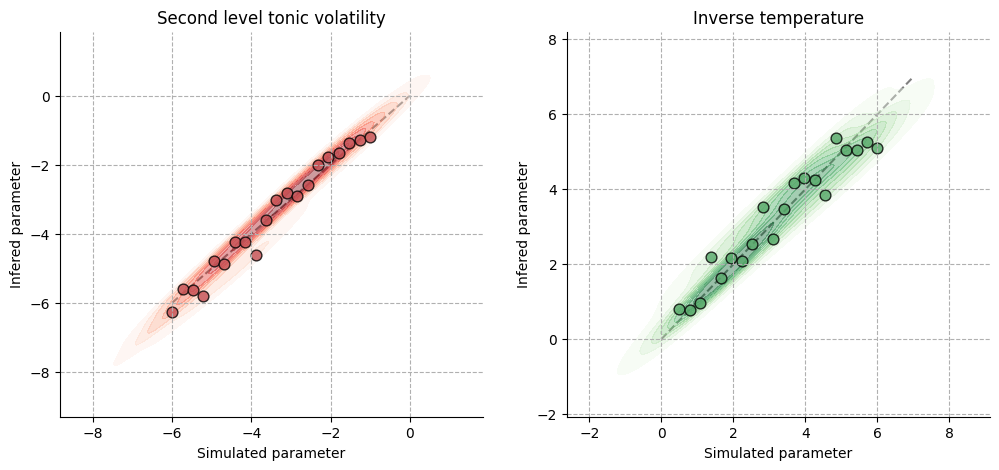

In [10]:
fig, axs = plt.subplots(figsize=(12, 5), ncols=2)

axs[0].plot([-6.0, 0.0], [-6.0, 0.0], color="grey", linestyle="--", zorder=-1)
axs[1].plot([0.0, 7.0], [0.0, 7.0], color="grey", linestyle="--", zorder=-1)

for var_name, refs, idx in zip(
    ["censored_volatility", "inverse_temperature"],
    [volatilities, temperatures],
    [0, 1],
):
    inferred_parameters = az.summary(two_level_hgf_idata, var_names=var_name)[
        "mean"
    ].tolist()

    sns.kdeplot(
        x=refs,
        y=inferred_parameters,
        ax=axs[idx],
        fill=True,
        cmap="Reds" if var_name == "censored_volatility" else "Greens",
        alpha=0.4,
    )

    axs[idx].scatter(
        refs,
        az.summary(two_level_hgf_idata, var_names=var_name)["mean"].tolist(),
        s=60,
        alpha=0.8,
        edgecolors="k",
        color="#c44e52" if var_name == "censored_volatility" else "#55a868",
    )

    axs[idx].grid(True, linestyle="--")
    axs[idx].set_xlabel("Simulated parameter")
    axs[idx].set_ylabel("Infered parameter")


axs[0].set_title("Second level tonic volatility")
axs[1].set_title("Inverse temperature")
sns.despine()

# System configuration

In [11]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pyhgf,jax,jaxlib

Last updated: Sun May 11 2025

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 9.2.0

pyhgf : 0.2.6
jax   : 0.4.31
jaxlib: 0.4.31

IPython   : 9.2.0
jax       : 0.4.31
sys       : 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:38:13) [GCC 12.3.0]
numpy     : 2.2.5
pyhgf     : 0.2.6
seaborn   : 0.13.2
matplotlib: 3.10.1
pymc      : 5.22.0
arviz     : 0.21.0

Watermark: 2.5.0

